In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score
from tqdm.notebook import tqdm
import time
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import numpy as np
torch.cuda.is_available()

True

In [2]:
# Lists to store accuracy values for each epoch
metrics_train_accuracy = []
metrics_val_accuracy = []
metrics_train_loss = []
metrics_val_loss = []
metrics_epoch = []

def display_graphs(epoch, accuracy, val_accuracy, loss, val_loss):
    
    if isinstance(loss, torch.Tensor):
        loss = loss.cpu()

    loss = loss.detach().numpy()

    metrics_epoch.append(epoch+1)
    metrics_train_accuracy.append(accuracy)
    metrics_val_accuracy.append(val_accuracy)
    metrics_train_loss.append(loss)
    metrics_val_loss.append(val_loss)
    
    if epoch != 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a figure with two subplots
        # Plot the accuracy graph in the first subplot
        axs[0].plot(metrics_epoch, metrics_train_accuracy, label='Training Accuracy', marker='o')
        axs[0].plot(metrics_epoch, metrics_val_accuracy, label='Validation Accuracy', marker='o')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_title('Training and Validation Accuracy')
        axs[0].set_ylim(0.5, 1)
        axs[0].set_xlim(1, num_epochs)
        axs[0].set_xticks(range(1, num_epochs + 1))
        axs[0].grid(True, linestyle='--', alpha=0.5)
        axs[0].legend()

        # Plot the loss graph in the second subplot
        axs[1].plot(metrics_epoch, metrics_train_loss, label='Training Loss', marker='o')
        axs[1].plot(metrics_epoch, metrics_val_loss, label='Validation Loss', marker='o')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].set_title('Training and Validation Loss')
        axs[1].set_ylim(0, 0.5)
        axs[1].set_xlim(1, num_epochs)
        axs[1].set_xticks(range(1, num_epochs + 1))
        axs[1].grid(True, linestyle='--', alpha=0.5)
        axs[1].legend()

        plt.tight_layout()
        plt.show()

### Parameters

In [3]:
num_classes = 6
batch_size = 4
num_epochs = 2
accumulation_steps = 2  # Number of steps to accumulate gradients before performing an optimizer step
evaluation_steps = 100  # Number of steps after which to evaluate the model
display_graphs_bool = True

### Model

In [ ]:
# Load the model from https://pytorch.org/vision/0.8/models.html or make your own
model = models.inception_v3(weights=None)

# Define optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Data

In [ ]:
# Load data from the data directory using ImageFolder
data_dir = r""
image_size = 299

# 4. Define PyTorch Transforms and include them in ImageFolder
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,)
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

print("Loading dataset...")
# Load the entire dataset
dataset = ImageFolder(data_dir, transform=transform)
print("Complete")

# Split the dataset into training and testing sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available

print(f"Moving model to device ({device})...")
model.to(device)  # Move the model to the device (CPU or GPU)
print("Complete")

print("Setting up model...")
model.train()  # Set the model to training mode

loss_function = nn.CrossEntropyLoss()  # Define the loss function
model.zero_grad()  # Reset gradients tensors
optimizer.zero_grad()  # Reset optimizer gradients
print("Complete")

total_steps = len(train_loader)  # Total number of steps in an epoch

display_graphs_bool = True

### Display Some Images

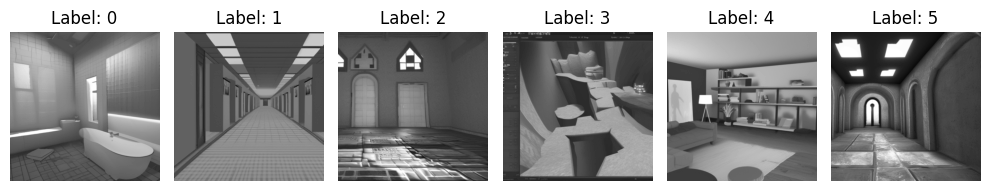

In [16]:
# Find the total number of label types in the train dataset
label_types = np.unique([label for _, label in train_dataset])
num_label_types = len(label_types)

# Display an image for each label type
fig, axs = plt.subplots(1, num_label_types, figsize=(10, 5))

for i, label_type in enumerate(label_types):
    # Find the index of the first image with the current label type
    label_indices = [index for index, (_, label) in enumerate(train_dataset) if label == label_type]
    label_index = label_indices[0]

    # Get the image and its label
    sample_image, sample_label = train_dataset[label_index]
    sample_image = sample_image.permute(1, 2, 0)  # Permute dimensions from (C, H, W) to (H, W, C)

    # Display the image with its label
    axs[i].imshow(sample_image, cmap="gray", vmin=0, vmax=1)
    axs[i].set_title(f"Label: {sample_label}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

### Save Callback

In [17]:
checkpoint_dir = r"Saves"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy):
    checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}_loss_{loss:.4f}_vloss{val_loss:.4f}_acc_{accuracy:.4f}_vacc{val_accuracy:.4f}.pt')
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, checkpoint_path)

### Training

In [ ]:
print("Beginning training...")
for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader, total=total_steps, leave=True)

    total_correct = 0
    total_samples = 0

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions, _ = model(inputs)
        loss = loss_function(predictions, labels)
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()
            optimizer.zero_grad()

        _, predicted_labels = torch.max(predictions, 1)  # Move this line inside the loop

        total_correct += (predicted_labels == labels).sum().item()  # Accumulate correct predictions
        total_samples += labels.size(0)  # Accumulate total samples

        progress_bar.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
        progress_bar.set_postfix(loss=loss.item())


    # Evaluate accuracy after the training loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_correct = 0
        val_samples = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            _, predicted_labels = torch.max(predictions, 1)

            val_correct += (predicted_labels == labels).sum().item()  # Accumulate correct predictions
            val_samples += labels.size(0)  # Accumulate total samples

            val_loss += loss_function(predictions, labels).item()

        val_loss /= len(test_loader)
        val_accuracy = val_correct / val_samples if val_samples != 0 else 0.0


    model.train()

    accuracy = total_correct / total_samples if total_samples != 0 else 0.0

    loss /= total_steps
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.6f}, Acc: {accuracy:.4f}, Val Loss: {val_loss:.6f}, Val Acc: {val_accuracy:.4f}")
    if display_graphs_bool == True:
        display_graphs(epoch, accuracy, val_accuracy, loss, val_loss)

    # Save model checkpoint
    save_checkpoint(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy)

### Make Single Predictions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
index = 0
input_image, label = test_dataset[index]
with torch.no_grad():
    input_image = input_image.to(device)

    output = model(input_image.unsqueeze(0))
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

image = input_image.squeeze().cpu().numpy()  # Move tensor to CPU with .cpu()
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.title("True label: {}, Predicted label: {}".format(label, predicted_label))
plt.axis('off')
plt.show()